## MACS 30250 PS1
### Dr. Richard W. Evans
### TA Zunda Xu
#### Submitted by Junho Choi

In [176]:
import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt
import dask.multiprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from dask import compute, delayed
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

### Question 1

Let us first load in the data necessary for this assignment.

In [105]:
bq_data = np.loadtxt('BQmat_orig.txt', delimiter=',')

#### Question 1-(a)

While I was considering normalizing this dataset, it seems that the dataset is already in a normalized state as its components all add up to 1. Therefore, we proceed to the next step.

In [106]:
print(bq_data.sum())

1.0


As $prcntl$ or "percentile" is given as $[0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01]$, we use this accordingly, together with the knowledge that the age runs from 18 to 95. We also create the array of midpoints for creating the mesh grid.

In [140]:
prcntl = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
ages = np.arange(18, 96)

midpoints_prcntl = []
for i, prcnt in enumerate(prcntl):
    if i == 0:
        midpoints_prcntl.append(0.5*prcnt)
        sum_prc = prcnt
    else:
        prev_sum = sum_prc
        sum_prc += prcnt
        midpoint = 0.5 * (sum_prc + prev_sum)
        midpoints_prcntl.append(midpoint)

midpoints_prcntl = np.array(midpoints_prcntl)

We create the "mesh grid," and plot the figure accordingly.

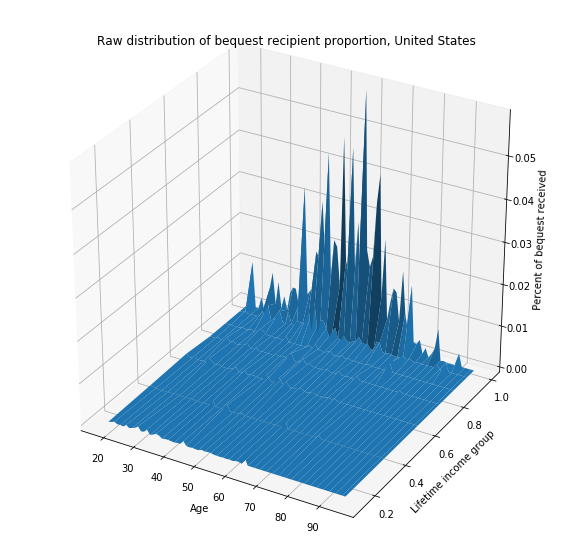

In [150]:
prcnt_mat, age_mat = np.meshgrid(midpoints_prcntl, ages)

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection ='3d')
ax.plot_surface(age_mat, prcnt_mat, bq_data)
ax.set_title('Raw distribution of bequest recipient proportion, United States')
ax.set_xlabel('Age')
ax.set_ylabel('Lifetime income group')
ax.set_zlabel('Percent of bequest received')
plt.show()

#### Question 1-(b)

For this exercise, we need to simulate data from the distribution that we have. We follow the below procedure for preparing the simulation.

In [168]:
## Since we have the probability data, we can simulate
## how many as we want!
bq_ravel = bq_data.ravel()
combo_howmany = len(bq_ravel)

total_lst = []
whichone = 0

for i in range(0, combo_howmany):
    j = i%7
    small_lst = [ages[whichone],
                 midpoints_prcntl[j],
                 bq_ravel[i]]
    
    if (i > 0) and (i % 7) == 0:
        whichone += 1

    total_lst.append(small_lst)

In [172]:
total_df = pd.DataFrame(total_lst)
total_df.columns = ['age', 'midpoint', 'probability']

print(total_df.head(10))

   age  midpoint  probability
0   18     0.125     0.000000
1   18     0.375     0.000284
2   18     0.600     0.000603
3   18     0.750     0.000000
4   18     0.850     0.000000
5   18     0.945     0.000000
6   18     0.995     0.000000
7   18     0.125     0.000179
8   19     0.375     0.000350
9   19     0.600     0.000000


Now we implement the simulation. Let us try drawing $N = 10000$ observations. As seen below, `simulated_df` contains the simulated age, midpoint (of the income range), associated probability, and the column number from the original dataframe (`total_df`).

In [187]:
whichbin = np.arange(0, combo_howmany)
N = 10000

## random seed for replicability
np.random.seed(60637)
simulated_lst = []
for i in range(0, N):
    draw = np.random.choice(whichbin, p=list(total_df.probability))
    simulated = [total_df.loc[draw, 'age'],
                 total_df.loc[draw, 'midpoint'],
                 total_df.loc[draw, 'probability'], draw]
    simulated_lst.append(simulated)
simulated_df = pd.DataFrame(simulated_lst)
simulated_df.columns = ['Simulated_age', 'Simulated_mdpt',
                        'Simulated_proba', 'Drawn_column']

print(simulated_df.head(10))

   Simulated_age  Simulated_mdpt  Simulated_proba  Drawn_column
0             38           0.995         0.032903           146
1             41           0.995         0.009385           167
2             35           0.995         0.007570           125
3             61           0.995         0.020657           307
4             60           0.995         0.017962           300
5             36           0.945         0.000722           131
6             50           0.995         0.011414           230
7             72           0.995         0.009173           384
8             37           0.995         0.004407           139
9             51           0.995         0.047140           237


Let us now implement KDE using this simulated data. First, we try to find the best bandwidth meaning the one that minimizes the sum of squared errors with respect to the original densities.

In [215]:
to_use = pd.DataFrame(
    simulated_df.loc[:, ['Simulated_age', 'Simulated_mdpt']])

## trying to find the best Gaussian KDE,
## by minimizing the sum of squared errors

starting_point = 0.005
best_bw = starting_point
best_sse = 100000000
original = np.vstack([item.ravel() for item in [age_mat, prcnt_mat]])

for i in range(1, 26):
    bw_contestant = starting_point * i
    kde = gaussian_kde(to_use.T, bw_method=bw_contestant)
    kde_fit = np.reshape(kde(original), age_mat.shape)
    kde_fit = kde_fit / kde_fit.sum()
    sse = ((kde_fit - bq_data)**2).sum()
    
    if sse < best_sse:
        best_sse = sse
        best_bw = bw_contestant

According to the above exercise, the best bandwidth is found to be 0.005.

In [216]:
print(best_bw)

0.005


Now we use the best bandwidth found above to implement Gaussian KDE and plot accordingly.

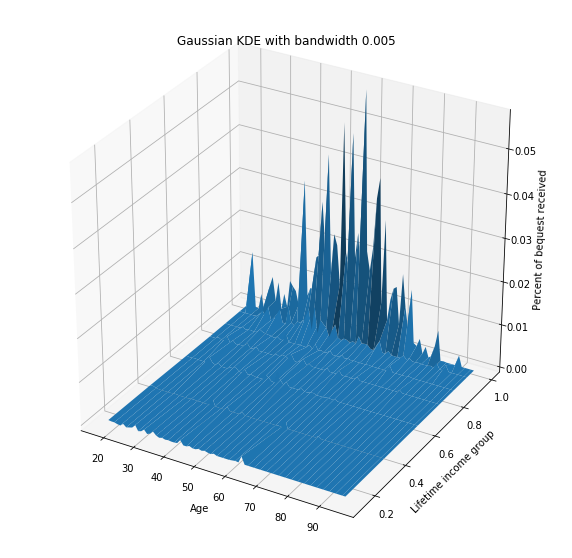

In [217]:
kde = gaussian_kde(to_use.T, bw_method=best_bw)
kde_fit = np.reshape(kde(original), age_mat.shape)
kde_fit = kde_fit / kde_fit.sum()

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection ='3d')
ax.plot_surface(age_mat, prcnt_mat, kde_fit)
ax.set_title('Gaussian KDE with bandwidth {}'.format(best_bw))
ax.set_xlabel('Age')
ax.set_ylabel('Lifetime income group')
ax.set_zlabel('Percent of bequest received')
plt.show()

Just for comparison, we plot another with a greater bandwidth (bandwidth of 0.125).

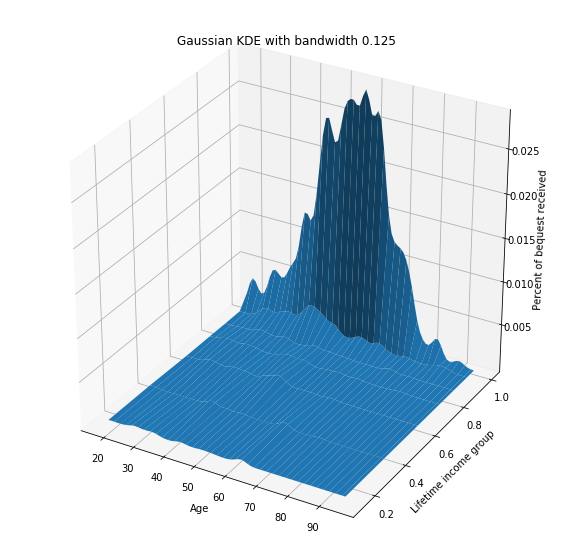

In [218]:
kde_comp = gaussian_kde(to_use.T, bw_method=0.125)
kde_fit_comp = np.reshape(kde_comp(original), age_mat.shape)
kde_fit_comp = kde_fit_comp / kde_fit_comp.sum()

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection ='3d')
ax.plot_surface(age_mat, prcnt_mat, kde_fit_comp)
ax.set_title('Gaussian KDE with bandwidth 0.125')
ax.set_xlabel('Age')
ax.set_ylabel('Lifetime income group')
ax.set_zlabel('Percent of bequest received')
plt.show()

We use the above `kde_fit` to answer the final question: what is the estimated density for bequest recipients who are age 61 in the 6th lifetime income category? My answer is found to be approximately $0.0009$ (i.e. $0.09\%$).

In [219]:
## age 61: 61-18=43, row index 43
## category 6: 6-1=5, column index 5

print(kde_fit[43][5])

0.0008999999999999999


However, if we do consider the "best" bandwidth to be the one that smoothly plots the surface, maybe we should instead look at the one with bandwidth of 0.125. Then, the answer to the above question is approximately $0.000985$ (i.e. $0.0985\%$).

In [221]:
print(kde_fit_comp[43][5])

0.0009849972056445234


### Question 2

Before proceeding with the sub-questions, let us prepare the data, by reading it in, dropping the rows with missing data, and checking the column names.

In [33]:
df = pd.read_csv("auto.csv", na_values='?')
df.dropna(inplace=True)

In [34]:
df.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name'],
      dtype='object')

Let us create the additional variables, `mpg_high`, `orgn1`, and `orgn2`.

In [36]:
mpg_med = df.mpg.median()

In [37]:
df['mpg_high'] = 0
df.loc[df['mpg'] >= mpg_med, 'mpg_high'] = 1
df['orgn1'] = 0
df.loc[df['origin'] == 1, 'orgn1'] = 1
df['orgn2'] = 0
df.loc[df['origin'] == 2, 'orgn2'] = 1

Let us set the explanatory variables (`X`) and dependent variable (`y`).

In [38]:
X_vars = ['cylinders', 'displacement', 'horsepower', 'weight',
          'acceleration', 'orgn1', 'orgn2']
X = df.loc[:, X_vars].values
y = df.loc[:, 'mpg_high'].values

#### Question 2-(a)

In the below code chunk, we run the 100 repeats (or bootstraps) of the Logistic regression that we are asked to do, with the specification for random states to ensure replicability.

In [117]:
repeat = 100
rstate = 60636

errate_0_lst = []
errate_1_lst = []
inaccuracy_lst = []

start_time = timeit.default_timer()

for i in range(0, repeat):
    rstate += 1
    LR = LogisticRegression(max_iter=1000,
        solver='lbfgs', n_jobs=None, random_state=rstate)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.35,
                         random_state=rstate)
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_test)
    report = classification_report(y_true=y_test,
        y_pred=y_pred, output_dict=True)
    errate_0 = 1 - report['0']['precision']
    errate_1 = 1 - report['1']['precision']
    inaccuracy = 1 - (y_pred == y_test).mean()
    
    errate_0_lst.append(errate_0)
    errate_1_lst.append(errate_1)
    inaccuracy_lst.append(inaccuracy)
    
errate_precision_0 = sum(errate_0_lst)/len(errate_0_lst)
errate_precision_1 = sum(errate_1_lst)/len(errate_1_lst)
inaccuracy_errate = sum(inaccuracy_lst)/len(inaccuracy_lst)

elapsed_time = timeit.default_timer() - start_time

The elapsed time is approximately $8.5941$ seconds.

In [178]:
print(elapsed_time)

8.594142400001147


In Problem Set 7 of MACS 30150 class, we defined the error rate to be $(1-\text{precision})$. Precision can be calculated with respect to each of the possible values in the categorical dependent variable. In addition, the error rate can also be defined as $(1-\text{accuracy})$. Therefore below are presented the three variants of error rates. All of these should be equal to the corresponding error rates calculated in Question 2-(b).

In [126]:
print("Average error rate with respect to predicting mpg_high=0 is",errate_precision_0)
print("Average error rate with respect to predicting mpg_high=1 is",errate_precision_1)
print("Average error rate with respect to overall inaccuracy is",inaccuracy_errate)

Average error rate with respect to predicting mpg_high=0 is 0.09760633642960057
Average error rate with respect to predicting mpg_high=1 is 0.13142330028571395
Average error rate with respect to overall inaccuracy is 0.11608695652173917


#### Question 2-(b)

It can be checked that I have four cores on my machine.

In [112]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print('Number of available cores is', num_cores)

Number of available cores is 4


With `i` denoting the `i`th bootstrap conducted, `seed` referring to the initial random seed, and `X` and `y` referring to the data, I define the below `sim_stats` to be used in conjunction with parallel computing.

In [133]:
def sim_stats(i, seed, X, y):
    LR = LogisticRegression(max_iter=1000,
        solver='lbfgs', n_jobs=1, random_state=seed+i)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.35,
                         random_state=seed+i)
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_test)
    report = classification_report(y_true=y_test,
        y_pred=y_pred, output_dict=True)
    errate_0 = 1 - report['0']['precision']
    errate_1 = 1 - report['1']['precision']
    inaccuracy = 1 - (y_pred == y_test).mean()
    
    return errate_0, errate_1, inaccuracy

Let us try to use the below code to calculate all of the error rates and also produce (and store) the average error rates.

In [134]:
start_time_dask = timeit.default_timer()

lazy_values = []
for i in range(0, repeat):
    lazy_values.append(delayed(sim_stats)(i, 60637, X, y))

results_par = compute(*lazy_values,
                      scheduler=dask.multiprocessing.get,
                      num_workers=num_cores)

errate_0_dask = []
errate_1_dask = []
inaccuracy_dask = []

for j in results_par:
    errate_0_dask.append(j[0])
    errate_1_dask.append(j[1])
    inaccuracy_dask.append(j[2])    

errate_dask_0 = sum(errate_0_dask)/len(errate_0_dask)
errate_dask_1 = sum(errate_1_dask)/len(errate_1_dask)
inaccuracy_dask = sum(inaccuracy_dask)/len(inaccuracy_dask)    

elapsed_time_dask = timeit.default_timer() - start_time_dask

Surprisingly, the elapsed time using Dask was longer for my computer (approximately $22.0123$ seconds). What might be the reason behind this? A StackOverflow post (`https://stackoverflow.com/questions/53320649/slow-dask-performance-compared-to-native-sklearn`) helped me understand this problem, as it describes that perhaps, instead of speeding up the performance of computation, Dask is allocating the cores so that more data can be managed. But because the original setting in Question 2-(a) was pretty easy for the computer to do anyways, it seems that the elapsed time has increased. Another suggestion was that this may occur when the computer has low memory in general (suggesting that perhaps I need to change my machine).

In [177]:
print(elapsed_time_dask)

22.012280800001463


The average error rates are shown to be the same as the ones in Question 2-(a).

In [137]:
print("Average error rate with respect to predicting mpg_high=0 is",errate_dask_0)
print("Average error rate with respect to predicting mpg_high=1 is",errate_dask_1)
print("Average error rate with respect to overall inaccuracy is",inaccuracy_dask)

Average error rate with respect to predicting mpg_high=0 is 0.09760633642960057
Average error rate with respect to predicting mpg_high=1 is 0.13142330028571395
Average error rate with respect to overall inaccuracy is 0.11608695652173917
